In [412]:
from enum import Enum
from string import printable
import time
import math

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

#Google cloud API imports
from google.cloud import translate_v2 as translate
from google.cloud.exceptions import Forbidden
from google.cloud.exceptions import BadRequest

from google.cloud import language
from google.cloud.language import enums as gc_enums
from google.cloud.language import types as gc_types

import nltk
from nltk.corpus import sentiwordnet as swn
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer

from keras.preprocessing.text import Tokenizer
import keras.preprocessing.sequence

import tensorflow as tf

from keras import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout

from sklearn.model_selection import train_test_split

from tqdm.auto import tqdm
tqdm.pandas() #allows progress bar support for pandas mapping functions
from keras_tqdm import TQDMNotebookCallback #tqdm progress bars for keras 

pd.options.mode.chained_assignment = None  # default='warn'

%matplotlib inline
%env GOOGLE_APPLICATION_CREDENTIALS translationKeys.json

env: GOOGLE_APPLICATION_CREDENTIALS=translationKeys.json


In [342]:
#The dataset provided consists of three csv files, each with slightly different schema
DATASET_1 = "dataset/7282_1.csv"
DATASET_2 = "dataset/Datafiniti_Hotel_Reviews.csv"
DATASET_3 = "dataset/Datafiniti_Hotel_Reviews_Jun19.csv"

TEST_PROPORTION = 0.25

USE_TRANSLATOR = True

TRANSLATOR_OPTIONS = Enum("OPTIONS", "TRANSLATE REMOVE THRESHOLD")
TRANSLATOR_FUNCTIONALITY = TRANSLATOR_OPTIONS.TRANSLATE #options are "translate", which translates non-english text to english, and 
                                        # "remove", which drops records with non-english text from the training set
TRANSLATOR_THRESHOLD=0.05

## 1. Exploratory Analysis and Data Cleaning

In [69]:
def clean_df(frame):
    
    #because I was having trouble with non-latin characters in strings (Japanese charsets, etc.) this project
    # encodes all strings as utf-8 codepoints and decodes to strings as necessary. This feels sub-optimal, but
    # as it works, I will keep it like this at this stage
    frame["reviews.text"] = frame["reviews.text"].str.encode("utf-8")

    if ("translated_text" in frame.columns):
        frame["translated_text"] = frame["translated_text"].str.encode("utf-8")
    
    #keep only ratings that have a review attached (that is, not Na or empty or only whitespace)
    frame = frame[~frame["reviews.text"].isnull()] 
    frame = frame[frame["reviews.text"] != ""]
    frame = frame[~frame["reviews.text"].str.isspace()]
    
    frame = frame.reset_index(drop=True)
    
    return frame

def load_dataset(filename):
    frame = pd.read_csv(filename)
    frame = clean_df(frame)
    return frame

def save_dataset(frame, filename):
    
    frame = frame.copy()
    
    frame["reviews.text"] = frame["reviews.text"].map(lambda x: x.decode("utf-8"))
    
    if ("translated_text" in frame.columns):
        frame["translated_text"] = frame["translated_text"].map(lambda x: x.decode("utf-8"))
        
    frame.to_csv(filename, encoding="utf-8")
    

### Dataset 1

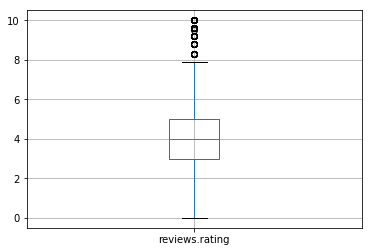

In [4]:
df_1 = load_dataset(DATASET_1)
#print(df)
#df_1.head()

df_1.boxplot(column="reviews.rating")


In [5]:
print(df_1["reviews.rating"].value_counts())

5.0     12664
4.0      9747
3.0      5705
1.0      3065
2.0      2978
0.0       337
10.0      101
9.6        53
9.2        49
4.3        26
4.8        25
8.3        25
7.9        24
7.5        24
8.8        24
4.2        22
3.4        17
4.1        14
6.3        14
7.1        13
4.5        13
6.7        12
5.4         9
4.6         7
3.1         7
5.8         6
4.4         6
3.3         6
4.7         6
4.9         6
2.4         4
2.5         3
3.8         3
3.7         2
3.2         2
3.9         2
2.8         1
1.3         1
9.5         1
1.5         1
6.0         1
2.9         1
7.0         1
Name: reviews.rating, dtype: int64


In [6]:
print(df_1[df_1["reviews.rating"] > 5].head())


              address categories      city country  latitude  longitude  \
4448  Taragaon Boudha     Hotels  Alliance      US   27.7216  85.355959   
4449  Taragaon Boudha     Hotels  Alliance      US   27.7216  85.355959   
4450  Taragaon Boudha     Hotels  Alliance      US   27.7216  85.355959   
4451  Taragaon Boudha     Hotels  Alliance      US   27.7216  85.355959   
4452  Taragaon Boudha     Hotels  Alliance      US   27.7216  85.355959   

                         name postalCode province          reviews.date  \
4448  Hyatt Regency Kathmandu      44601       OH  2015-08-11T00:00:00Z   
4449  Hyatt Regency Kathmandu      44601       OH  2016-01-12T00:00:00Z   
4450  Hyatt Regency Kathmandu      44601       OH  2015-06-22T00:00:00Z   
4451  Hyatt Regency Kathmandu      44601       OH  2016-05-17T00:00:00Z   
4452  Hyatt Regency Kathmandu      44601       OH  2016-07-09T00:00:00Z   

         reviews.dateAdded  reviews.doRecommend  reviews.id  reviews.rating  \
4448  2016-11-11T23

In [7]:
print(df_1[df_1["reviews.rating"] == 0].head())

                                      address  \
57                      2113 Sapp Brothers Dr   
58                             2860 Grand Ave   
59  142 Park Place Us 181 Business At Park Pl   
79                      435 E Avenida Olancha   
97                              316 N Main St   

                                          categories          city country  \
57                             Lodging,Hotels,Motels      Percival      US   
58                                Hotels,Restaurants    Los Olivos      US   
59                                            Hotels        Kenedy      US   
79                                      Hotels,Hotel  Palm Springs      US   
97  Motels,Hotels,Restaurants,Bed & Breakfast & Inns       Neihart      US   

     latitude   longitude                     name postalCode province  \
57  40.689730  -95.788826  Americas Best Value Inn      51648       IA   
58  34.664684 -120.115036               Intermezzo      93441       CA   
59  28.793795 

From the unique values in DATASET_1, it seems that, while most of the reviews are rated on an integer scale between 1 and 5, at least some of the reviews are rated from 1.0-10.0. These reviews should be removed or re-scaled (I have chosen to remove them, as there are comparatively very few of them and there may be differences between what a user means by choosing two equivalent ratings on the two scales - ie. a 8/10 rating may have different connotations on average to a 4/5 rating.)

Note: It is impossible to tell which of the remaining reviews are actually rated out of 10 rather than 5 - however, assuming the distribution of ratings out of 10 is similar to the distribution for ratings out of 5, there should be very few of these and their effect on any statistical analysis should be minor.

Additionally, a quick glance at the 0 ratings suggests that these are not real reviews, but some artifact of the scraping process, and so should be removed as well.

In [8]:
df_1 = df_1[df_1["reviews.rating"].isin([1.0,2.0,3.0,4.0,5.0])]

print(df_1["reviews.rating"].value_counts())

5.0    12664
4.0     9747
3.0     5705
1.0     3065
2.0     2978
Name: reviews.rating, dtype: int64


count    34159.000000
mean       256.185544
std        219.689435
min          1.000000
25%        103.000000
50%        227.000000
75%        330.000000
max       3827.000000
Name: reviews.length, dtype: float64


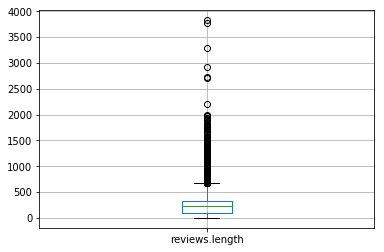

In [9]:
df_1["reviews.length"] = df_1["reviews.text"].str.len()

print(df_1["reviews.length"].describe())

df_1.boxplot(column="reviews.length")


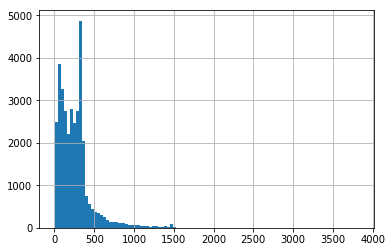

In [10]:
df_1["reviews.length"].hist(bins=100)

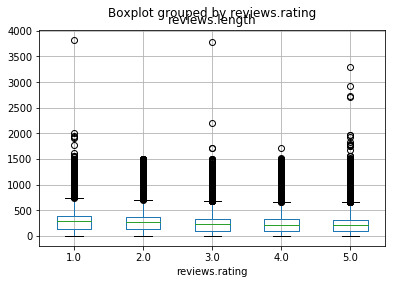

In [11]:
df_1.boxplot(column="reviews.length", by="reviews.rating")

Beacuse there is a large drop off in the number of reviews at around 450 characters, I have decided to remove all reviews longer than that, as their outlier status may negatively affect their usefulness in creating accurate sentiment analysis methodologies

To remove reviews that are too small to be of use in determining sentiment, I have decided to use the 25th percentile length value (~100) as the minimum cutoff point.

In [12]:
LOWER_BOUND = 100
UPPER_BOUND = 450

orig_size = df_1["reviews.text"].count()

df_1 = df_1[df_1["reviews.length"].between(LOWER_BOUND, UPPER_BOUND)]


new_size = df_1["reviews.text"].count()

print("Number of records in pruned dataset: {}", new_size)
print("Percentage of records kept: %{}", (new_size/orig_size * 100))


Number of records in pruned dataset: {} 22395
Percentage of records kept: %{} 65.56105272402588


With around 65% of records kept from the dataset, I feel that these upper and lower bounds for length strike a good balance between removing outliers and keeping a large enough corpus to train any sentiment analysis models with.

### Dataset 2

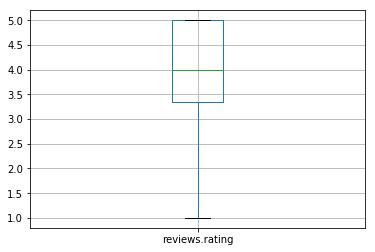

In [13]:
df_2 = load_dataset(DATASET_2)
df_2.head()

df_2.boxplot(column="reviews.rating")

In [14]:
print(df_2["reviews.rating"].value_counts())

5.00    4384
4.00    2397
3.00    1186
1.00     572
2.00     561
4.80     162
4.60     155
4.40     102
3.75      91
4.15      78
3.95      52
3.55      50
3.35      40
3.15      37
2.90      34
2.70      23
2.50      19
2.30      12
2.10      11
1.65       8
1.45       6
4.50       4
1.90       4
3.25       2
3.50       2
1.25       2
4.25       2
2.75       1
4.75       1
3.45       1
Name: reviews.rating, dtype: int64


For DATASET_2, all reviews are rated on the 1-5 scale, but a small minority are non-integer ratings. Here, it makes sense to round these ratings to the nearest integer

In [15]:
df_2["reviews.rating"] = df_2["reviews.rating"].round()

print(df_2["reviews.rating"].value_counts())

5.0    4702
4.0    2778
3.0    1324
2.0     615
1.0     580
Name: reviews.rating, dtype: int64


count    9999.000000
mean      324.666367
std       295.447557
min         1.000000
25%       201.000000
50%       298.000000
75%       344.000000
max      5939.000000
Name: reviews.length, dtype: float64


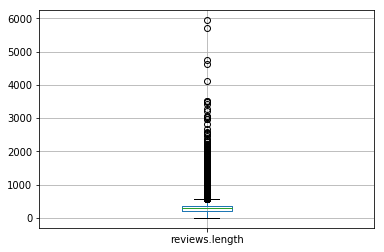

In [16]:
df_2["reviews.length"] = df_2["reviews.text"].str.len()

print(df_2["reviews.length"].describe())

df_2.boxplot(column="reviews.length")

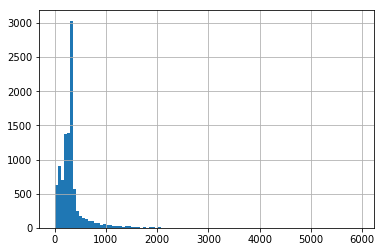

In [17]:
df_2["reviews.length"].hist(bins=100)

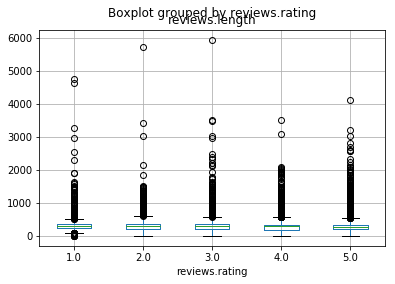

In [18]:
df_2.boxplot(column="reviews.length", by="reviews.rating")

In [19]:
orig_size = df_2["reviews.text"].count()

df_2 = df_2[df_2["reviews.length"].between(LOWER_BOUND, UPPER_BOUND)]


new_size = df_2["reviews.text"].count()

print("Number of records in pruned dataset: {}", new_size)
print("Percentage of records kept: %{}", (new_size/orig_size * 100))

Number of records in pruned dataset: {} 7474
Percentage of records kept: %{} 74.74747474747475


### Dataset 3

5    4840
4    2849
3    1190
1     567
2     554
Name: reviews.rating, dtype: int64


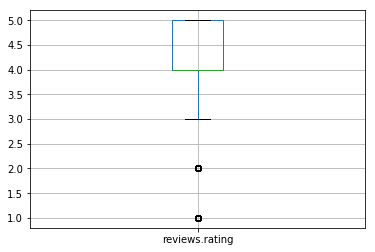

In [20]:
df_3 = load_dataset(DATASET_3)

df_3.head()

df_3.boxplot(column="reviews.rating")
print(df_3["reviews.rating"].value_counts())

In DATASET_3, all of the reviews are already on the integer 1-5 scale, so there is nothing that needs to be done.

count    10000.000000
mean       651.899600
std        593.559418
min          8.000000
25%        302.000000
50%        462.000000
75%        812.250000
max      14254.000000
Name: reviews.length, dtype: float64


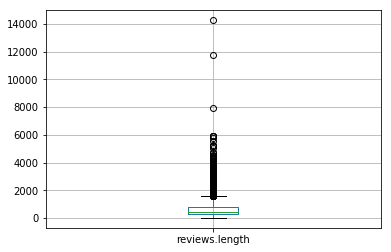

In [21]:
df_3["reviews.length"] = df_3["reviews.text"].str.len()

print(df_3["reviews.length"].describe())

df_3.boxplot(column="reviews.length")


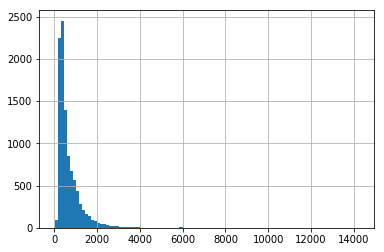

In [22]:
df_3["reviews.length"].hist(bins=100)

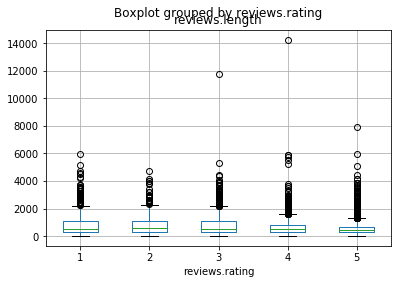

In [23]:
df_3.boxplot(column="reviews.length", by="reviews.rating")

In [24]:
orig_size = df_3["reviews.text"].count()

df_3 = df_3[df_3["reviews.length"].between(LOWER_BOUND, UPPER_BOUND)]


new_size = df_3["reviews.text"].count()

print("Number of records in pruned dataset: {}".format(new_size))
print("Percentage of records kept: {}%".format(new_size/orig_size * 100))

Number of records in pruned dataset: 4871
Percentage of records kept: 48.71%


Using the Upper and Lower length bounds for Dataset 1 here have resulted in a significantly larger number of records being eliminated

### Combining the Three Datasets

In [25]:
#Find the columns that are present in each of the three datasets, and make sure that there aren't any important columns
# (review text, title, rating, etc.) that are functionally identical, but named differently
columns_intersection = set.intersection(set(df_1.columns.values),set(df_2.columns.values), set(df_3.columns.values))
print(columns_intersection)

{'reviews.date', 'longitude', 'reviews.userProvince', 'reviews.rating', 'categories', 'postalCode', 'latitude', 'reviews.length', 'reviews.username', 'name', 'city', 'province', 'reviews.title', 'address', 'reviews.text', 'reviews.userCity', 'country'}


In [26]:
#now concatenate the chosen data sources on the schema intersection

df = pd.concat([df_1,df_2,df_3], join="inner")

#remove unnecessary columns
df = df[["reviews.rating", "reviews.text", "reviews.length"]]


#remove reviews with the same rating and text
df = df.drop_duplicates()

df = df.reset_index(drop=True)

print(df.head())

print(len(df))

   reviews.rating                                       reviews.text  \
0             4.0  b"Pleasant 10 min walk along the sea front to ...   
1             5.0  b"Really lovely hotel. Stayed on the very top ...   
2             5.0  b'Ett mycket bra hotell. Det som drog ner bety...   
3             5.0  b'We stayed here for four nights in October. T...   
4             5.0  b'We loved staying on the island of Lido! You ...   

   reviews.length  
0             194  
1             252  
2             136  
3             354  
4             326  
34223


In [27]:
print(df.loc[789,:])

reviews.rating                                                    5
reviews.text      b'Americinn on the Au Sable river is a gem! Ve...
reviews.length                                                  327
Name: 789, dtype: object


In [28]:
df.count()

reviews.rating    34223
reviews.text      34223
reviews.length    34223
dtype: int64

In [29]:
df[df["reviews.text"] == ""]


,reviews.rating,reviews.text,reviews.length


## 2. Translation of non-English reviews 

In [31]:
print("Total number of characters in dataset: {:,.0f}".format(df["reviews.length"].sum()))
print("At $20 per million characters, using google cloud translate would cost ${:,.2f}".format(df["reviews.length"].sum() / 1000000 * 20))

Total number of characters in dataset: 9,075,527
At $20 per million characters, using google cloud translate would cost $181.51


Given the cost of detecting and translating the languages of each review, it is unfeasible for me to use this in any data analytics pipeline in this project. However, to examine the usefullness of translation as a pre-processing step, I will create a smaller dataset (1000 records) which will be translated and used in each sentiment analysis approach.

In [32]:
df_small = df.loc[0:999, :]

print(df_small.head())

print(len(df_small))
print("Total number of characters in dataset: {:,.0f}".format(df_small["reviews.length"].sum()))
print("At $20 per million characters, using google cloud translate would cost at least ${:,.2f}".format(df_small["reviews.length"].sum() / 1000000 * 20))

   reviews.rating                                       reviews.text  \
0             4.0  b"Pleasant 10 min walk along the sea front to ...   
1             5.0  b"Really lovely hotel. Stayed on the very top ...   
2             5.0  b'Ett mycket bra hotell. Det som drog ner bety...   
3             5.0  b'We stayed here for four nights in October. T...   
4             5.0  b'We loved staying on the island of Lido! You ...   

   reviews.length  
0             194  
1             252  
2             136  
3             354  
4             326  
1000
Total number of characters in dataset: 254,655
At $20 per million characters, using google cloud translate would cost at least $5.09


In [34]:
client = translate.Client()

#uses the google cloud translate API to detect the text language, returning the language and the confidence
def detect_language(text):

    #get the translation from the API (allowing for a few seconds to breathe when at the rate limit)
    while(True):
        try:
            detection = client.detect_language(text.decode("utf-8"))
        except Forbidden as e:
            #print(e.message)
            
            #if we're hitting the rate limit, wait a second and try again
            if e.message == "POST https://translation.googleapis.com/language/translate/v2/detect: User Rate Limit Exceeded":
                time.sleep(1)
                continue
            else: raise #otherwise, throw the error as usual
        break
        
    language = detection["language"]
    
    #because the API says that the confidence value is not always available, give a confidence value of 1 
    # (full confidence) if the confidence is not given to us
    
    confidence = detection["confidence"] if "confidence" in detection else 1
    
    return language, confidence
    
#uses the google cloud translate API to
#print(detect_language("aaaaaaa"))

def translate_text(text, source_lang="en", target_lang="en"):
    
    while(True):
        try:
            translation = client.translate(text.decode("utf-8"), source_language=source_lang, target_language=target_lang)
        except Forbidden as e:
            #if we're hitting the rate limit, wait a second and try again
            if e.message == "POST https://translation.googleapis.com/language/translate/v2/detect: User Rate Limit Exceeded":
                time.sleep(1)
                continue
            else: raise #otherwise, throw the error as usual
        except BadRequest as e:
                print(text.decode("utf-8"), " ", source_lang, "-", target_lang)
                raise
        break
    
    return translation["translatedText"].encode("utf-8")



In [35]:
def translate_dataframe(frame, redetect_languages=False, translator_functionality=TRANSLATOR_FUNCTIONALITY):
    
    #if selected, skip translating by just copying the untranslated text to the translated text column
    if USE_TRANSLATOR == False:
        frame["translated_text"] = frame["reviews.text"]
        return frame
    
    #skip if we already have detected languages and are not explicitly re-collecting them
    if ("detected_language" not in frame.columns) or (redetect_languages==True): 
        frame.loc[:,"detected_language"] = frame["reviews.text"].progress_map(detect_language)
        
    #save the detected languages so further testing and work doesn't require going through the process of
    #requesting language detection again
    df.to_csv("reviewratings_withlanguagedetection.csv")
    
    
    #now take all the reviews not in the source language and deal with them according to the functionality option set
    
    if translator_functionality == TRANSLATOR_OPTIONS.TRANSLATE:
        pass
        
        frame.loc[:,"translated_text"] = frame.progress_apply(lambda x: translate_text(x["reviews.text"], 
                                                                                 source_lang=x["detected_language"][0])
                                                            if x["detected_language"][0] != "en"
                                                            else x["reviews.text"]
                                                        ,axis=1) 
        
    elif translator_functionality == TRANSLATOR_OPTIONS.REMOVE:
        
        frame = frame[frame["detected_language"][0] != "en"]
        frame = frame.reset_index(drop=True)
        frame.loc[:,"translated_text"] = frame["reviews.text"]
        
    elif translator_functionality == TRANSLATOR_OPTIONS.THRESHOLD:
        
        frame = frame[frame["detected_language"][0] != "en" and frame["detected_language"][1] > TRANSLATOR_THRESHOLD]
        frame = frame.reset_index(drop=True)
        frame["translated_text"] = [row["reviews.text"] if row["detected_language"][0] == "en" 
                                    else translate_text(row["reviews.text"], source_lang=row["detected_language"][0])
                                    for row in frame]
        pass
    
    
    return frame

#test_df = df.head().copy()
#df_detected = translate_dataframe(test_df)
#print(df_detected["detected_language"].head())


In [70]:

#first test using the first 5 records (of which one is in swedish)

df_tiny = df.head().copy()

df_tiny = translate_dataframe(df_tiny)

print(df_tiny)


   reviews.rating                                       reviews.text  \
0             4.0  b"Pleasant 10 min walk along the sea front to ...   
1             5.0  b"Really lovely hotel. Stayed on the very top ...   
2             5.0  b'Ett mycket bra hotell. Det som drog ner bety...   
3             5.0  b'We stayed here for four nights in October. T...   
4             5.0  b'We loved staying on the island of Lido! You ...   

   reviews.length detected_language  \
0             194           (en, 1)   
1             252           (en, 1)   
2             136           (sv, 1)   
3             354           (en, 1)   
4             326           (en, 1)   

                                     translated_text  
0  b"Pleasant 10 min walk along the sea front to ...  
1  b"Really lovely hotel. Stayed on the very top ...  
2  b'A very good hotel. What pulled down the grad...  
3  b'We stayed here for four nights in October. T...  
4  b'We loved staying on the island of Lido! You ...  


In [71]:
print(df_tiny)

save_dataset(df_tiny, "df_tiny.csv")

df_tiny = load_dataset("df_tiny.csv")
print(df_tiny)

   reviews.rating                                       reviews.text  \
0             4.0  b"Pleasant 10 min walk along the sea front to ...   
1             5.0  b"Really lovely hotel. Stayed on the very top ...   
2             5.0  b'Ett mycket bra hotell. Det som drog ner bety...   
3             5.0  b'We stayed here for four nights in October. T...   
4             5.0  b'We loved staying on the island of Lido! You ...   

   reviews.length detected_language  \
0             194           (en, 1)   
1             252           (en, 1)   
2             136           (sv, 1)   
3             354           (en, 1)   
4             326           (en, 1)   

                                     translated_text  
0  b"Pleasant 10 min walk along the sea front to ...  
1  b"Really lovely hotel. Stayed on the very top ...  
2  b'A very good hotel. What pulled down the grad...  
3  b'We stayed here for four nights in October. T...  
4  b'We loved staying on the island of Lido! You ...  
  

In [41]:
#load_dataset("df_small.csv") # skip translating by loading a pre-translated dataframe

#detecting and translating the truncated dataset
df_small = translate_dataframe(df_small)

C:\Users\lenovo\Anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\lenovo\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [42]:
print(df_small)
save_dataset(df_small, "df_small.csv")


     reviews.rating                                       reviews.text  \
0               4.0  b"Pleasant 10 min walk along the sea front to ...   
1               5.0  b"Really lovely hotel. Stayed on the very top ...   
2               5.0  b'Ett mycket bra hotell. Det som drog ner bety...   
3               5.0  b'We stayed here for four nights in October. T...   
4               5.0  b'We loved staying on the island of Lido! You ...   
5               4.0  b'ottimo soggiorno e ottima sistemazione nei g...   
6               3.0  b'Gnstiger Ausgangspunkt fr Venedig Besuche. R...   
7               4.0  b'Lidoen er perfekt til et par dages ro og afs...   
8               4.0  b'Accueil chaleureux, en franais Changement du...   
9               3.0  b'It was ok hotel is nice from in and out but ...   
10              4.0  b'Klasse Frhstck, freundliches und aufmerksame...   
11              4.0  b'Bardzo sympatyczna obsuga, klimat hotelu. wi...   
12              4.0  b'Bra o lugnt lge

[1000 rows x 5 columns]


## 3. Sentiment Analysis

### Approach 1: Google Natural Language API

In [73]:
# estimates the price for runnning sentiment analysis on a dataframe's reviews. This function assumes that this is
# the only use of the sentiment analysis API for the billing month, so actual prices may differ (as the first 
# 5000 units are free, and discounts are applied to units used after cetain thresholds are met on a monthly basis, not
# per use case), but this serves as a useful estimate when deciding whether to use this approach
def estimate_sentiment_price(frame):
    
    units = 0
    
    #print(len(frame["reviews.length"]))
    
    for i in frame["reviews.length"]:
        
        #print(i)
        #one unit for every 1000 characters in the text (rounded up)
        #
        #note: given that I have culled all reviews above 450 characters, all reviews here are worth 1 unit,
        # but this method will work to calculate units if I decide in future to include longer reviews
        units += math.ceil(i / 1000.0)
        
    price = 0
        
    while (units > 5000000):
        print(units)
        units -= 1000
        price += 0.25
            
    while units > 1000000:
        units -= 1000
        price += 0.5
            
    while units > 5000:
        units -= 1000
        price += 1
    
    return price    
    
print("Price to calculate sentiment scores for the entire cleaned dataset: ${:,.2f}".format(estimate_sentiment_price(df)))
print("Price to calculate sentiment scores for the truncated cleaned dataset: ${:,.2f}".format(estimate_sentiment_price(df_small)))






Price to calculate sentiment scores for the entire cleaned dataset: $30.00
Price to calculate sentiment scores for the truncated cleaned dataset: $0.00


In [76]:
lang_client = language.LanguageServiceClient()

def get_google_sentiment_score(text):
    
    #print(text.decode("utf-8"))
    
    document = gc_types.Document(content=text.decode("utf-8"), type="PLAIN_TEXT")
    
    #make sure we dont hit against any rate limits
    while(True):
        try:
            response = lang_client.analyze_sentiment(document=document)
        except Forbidden as e:
            time.sleep(1)
            continue
        break

    
    sentiment = response.document_sentiment

    return sentiment.score
    
print(get_google_sentiment_score(b"This is Great!"))
    
print(get_google_sentiment_score(b"This sucks!"))

print(get_google_sentiment_score(b"I'm ambivalent about this!"))

0.8999999761581421
-0.8999999761581421
-0.30000001192092896


In [77]:
def get_google_cloud_sentiment_scores_dataframe(frame):
    
    frame.loc[:,:]["gc_sentiment"] = frame["translated_text"].progress_map(get_google_sentiment_score)
    
    return frame
    
    
    

In [78]:
#test on the tiny dataset first to ensure that the API calls work

print(df_tiny)

df_tiny = get_google_cloud_sentiment_scores_dataframe(df_tiny)

print(df_tiny)

   Unnamed: 0  reviews.rating  \
0           0             4.0   
1           1             5.0   
2           2             5.0   
3           3             5.0   
4           4             5.0   

                                        reviews.text  reviews.length  \
0  b"Pleasant 10 min walk along the sea front to ...             194   
1  b"Really lovely hotel. Stayed on the very top ...             252   
2  b'Ett mycket bra hotell. Det som drog ner bety...             136   
3  b'We stayed here for four nights in October. T...             354   
4  b'We loved staying on the island of Lido! You ...             326   

  detected_language                                    translated_text  \
0         ('en', 1)  b"Pleasant 10 min walk along the sea front to ...   
1         ('en', 1)  b"Really lovely hotel. Stayed on the very top ...   
2         ('sv', 1)  b'A very good hotel. What pulled down the grad...   
3         ('en', 1)  b'We stayed here for four nights in October. T...  

   Unnamed: 0  reviews.rating  \
0           0             4.0   
1           1             5.0   
2           2             5.0   
3           3             5.0   
4           4             5.0   

                                        reviews.text  reviews.length  \
0  b"Pleasant 10 min walk along the sea front to ...             194   
1  b"Really lovely hotel. Stayed on the very top ...             252   
2  b'Ett mycket bra hotell. Det som drog ner bety...             136   
3  b'We stayed here for four nights in October. T...             354   
4  b'We loved staying on the island of Lido! You ...             326   

  detected_language                                    translated_text  \
0         ('en', 1)  b"Pleasant 10 min walk along the sea front to ...   
1         ('en', 1)  b"Really lovely hotel. Stayed on the very top ...   
2         ('sv', 1)  b'A very good hotel. What pulled down the grad...   
3         ('en', 1)  b'We stayed here for four nights in October. T...  

In [79]:
df_small = get_google_cloud_sentiment_scores_dataframe(df_small)





C:\Users\lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


#### Evaluating resultant sentiment scores

In [82]:
print(df_small.loc[9,:])

reviews.rating                                                       3
reviews.text         b'It was ok hotel is nice from in and out but ...
reviews.length                                                     112
detected_language                                              (en, 1)
translated_text      b'It was ok hotel is nice from in and out but ...
gc_sentiment                                                      -0.2
Name: 9, dtype: object


In [91]:
print("Pearson co-efficient: ",df_small["reviews.rating"].corr(df_small["gc_sentiment"]))
print("Spearman co-efficient: ",df_small["reviews.rating"].corr(df_small["gc_sentiment"], method="spearman"))

Pearson co-efficient:  0.6544873197926278
Spearman co-efficient:  0.5898236866015896


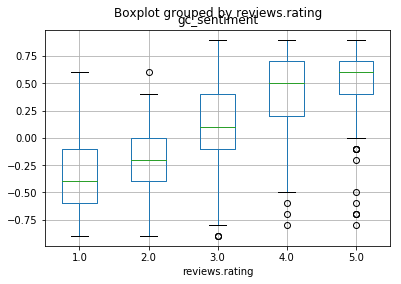

In [97]:
df_small.boxplot(column="gc_sentiment", by="reviews.rating")


With a correlation coefficient of ~+0.65, this method of obtaining sentiment scores seems to be very highly correlated 

To generate scores representing a the difference between the obtained sentiment scores and the given ratings, I will remap the sentiment scores from the range -1.0 to +1.0 to 1.0-5.0, and calculate the absolute difference between that and the review rating 

In [146]:
def remap_range(input, input_range=(-1.0,1.0),output_range=(1.0,5.0)):
    return ( (input - input_range[0]) / (input_range[1] - input_range[0]) ) * (output_range[1] - output_range[0]) + output_range[0]    

def remap_sentiment_score(input):
    
    return remap_range(input, input_range=(-1.0,1.0), output_range=(1.0,5.0)) 


#print(remap_sentiment_rating(-1))

def get_sentiment_difference_score(sentiment_score,rating):

    #remap the sentiment scores to the rating range (ie. 1.0-5.0)
    remapped_sentiment_score = remap_sentiment_score(sentiment_score)
    #print(remapped_sentiment_score)
    
    
    score_difference = 4 - abs(remapped_sentiment_score - rating)
    
    #print(score_difference)

    return remap_range(score_difference, input_range=(0.0,4.0), output_range=(0.0,1.0))


#make sure these functions do as they are expected
assert remap_sentiment_score(1.0) == 5
assert remap_sentiment_score(-1.0) == 1

assert get_sentiment_difference_score(1,5) == 1
assert get_sentiment_difference_score(-1,5) == 0


In [151]:
df_small["gc_sentiment_difference_rating"] = df_small.apply(lambda x: 
                                                            get_sentiment_difference_score(x["gc_sentiment"],
                                                                                          x["reviews.rating"]),
                                                           axis=1)




KeyError: 'gh_sentiment_difference_rating'

In [155]:
df_small

,reviews.rating,reviews.text,reviews.length,detected_language,translated_text,gc_sentiment,gc_sentiment_difference_rating
0,4.0,"b""Pleasant 10 min walk along the sea front to ...",194,"(en, 1)","b""Pleasant 10 min walk along the sea front to ...",0.2,0.85
1,5.0,"b""Really lovely hotel. Stayed on the very top ...",252,"(en, 1)","b""Really lovely hotel. Stayed on the very top ...",0.6,0.80
2,5.0,b'Ett mycket bra hotell. Det som drog ner bety...,136,"(sv, 1)",b'A very good hotel. What pulled down the grad...,0.3,0.65
3,5.0,b'We stayed here for four nights in October. T...,354,"(en, 1)",b'We stayed here for four nights in October. T...,0.6,0.80
4,5.0,b'We loved staying on the island of Lido! You ...,326,"(en, 1)",b'We loved staying on the island of Lido! You ...,0.7,0.85
5,4.0,b'ottimo soggiorno e ottima sistemazione nei g...,224,"(it, 1)",b'excellent stay and excellent accommodation i...,0.6,0.95
6,3.0,b'Gnstiger Ausgangspunkt fr Venedig Besuche. R...,311,"(de, 1)",b'Favorable starting point for visits to Venic...,0.0,1.00
7,4.0,b'Lidoen er perfekt til et par dages ro og afs...,130,"(da, 1)",b'The lido is perfect for a couple of days of ...,0.9,0.80
8,4.0,"b'Accueil chaleureux, en franais Changement du...",166,"(fr, 0.9191928505897522)","b'Warm welcome, in French Change of bed linen ...",0.9,0.80
9,3.0,b'It was ok hotel is nice from in and out but ...,112,"(en, 1)",b'It was ok hotel is nice from in and out but ...,-0.2,0.90


<Figure size 432x288 with 0 Axes>

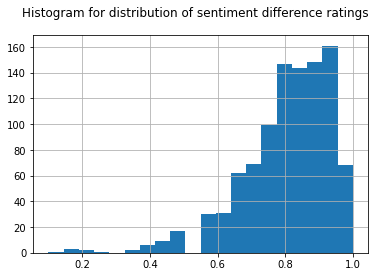

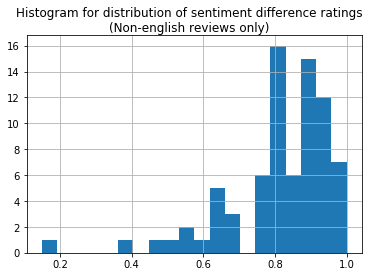

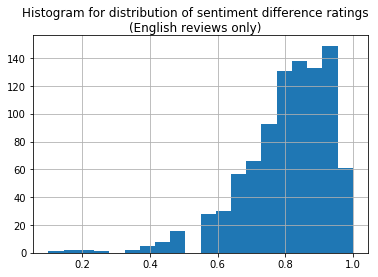

<Figure size 432x288 with 0 Axes>

In [189]:

df_small["gc_sentiment_difference_rating"].hist(bins=20)
plt.suptitle("Histogram for distribution of sentiment difference ratings")
plt.figure()

df_small[df_small["detected_language"].str[0] != "en"]["gc_sentiment_difference_rating"].hist(bins=20)
plt.suptitle("Histogram for distribution of sentiment difference ratings\n(Non-english reviews only)")
plt.figure()

df_small[df_small["detected_language"].str[0] == "en"]["gc_sentiment_difference_rating"].hist(bins=20)
plt.suptitle("Histogram for distribution of sentiment difference ratings\n(English reviews only)")
plt.figure()

Looking at the histograms for sentiment difference ratings, we can see that most reviews are given a very high score, indicating that there is a very high correlation between sentiment score and rating. This does not seem to be affected greatly by whether the reviews were translated from a non-english language, suggesting that the Google translate system does well at keeping relevant sentiment informtion when translating.

Hoewver, there are a small number where the sentiment score and the given review rating are very discordant, and it would be wourthwhile to drill into those reviews to examine where the discrepancy lies.

In [165]:
#sort the df by sentiment difference rating, and get the lowest 20 reviews to examine individually
df_worst_scores = df_small.sort_values("gc_sentiment_difference_rating").head(20)

df_worst_scores.loc[:,["translated_text", "reviews.rating", "gc_sentiment", "detected_language", "gc_sentiment_difference_rating"]]

,translated_text,reviews.rating,gc_sentiment,detected_language,gc_sentiment_difference_rating
755,b'the free wifii was very slow -- had to pay f...,5.0,-0.8,"(en, 1)",0.10
777,"b'The hotel was on the whole okay, only the su...",5.0,-0.7,"(de, 1)",0.15
86,"b""Let's face it, this is NOT in the Livermore ...",5.0,-0.7,"(en, 1)",0.15
911,b'It was terrible. Would never stayhere agian....,5.0,-0.7,"(en, 1)",0.15
793,b'We had our family reunion there and it was a...,1.0,0.6,"(en, 1)",0.20
177,"b'The rooms were OK, but there was no insulati...",5.0,-0.6,"(en, 1)",0.20
827,b'Great break but tv channels were not availab...,5.0,-0.5,"(en, 1)",0.25
428,b'The food at breakfast was good but we had to...,4.0,-0.8,"(en, 1)",0.35
810,"b""We've lived in the area for twelve years but...",1.0,0.3,"(en, 1)",0.35
892,b'After 22hrs. of driving all I was looking fo...,1.0,0.2,"(en, 1)",0.40


In [171]:
print(df_worst_scores.loc[755,:]["translated_text"].decode("utf-8"), "\n")

print(df_worst_scores.loc[777,:]["translated_text"].decode("utf-8"), "\n")

print(df_worst_scores.loc[775,:]["translated_text"].decode("utf-8"), "\n")

print(df_worst_scores.loc[867,:]["translated_text"].decode("utf-8"), "\n")

the free wifii was very slow -- had to pay for wifii (price was ok) one can only get 3 devices online - they should increase the number of devices now that everyone carries at least a smart phone, ipad and maybe a laptop 

The hotel was on the whole okay, only the surrounding area with the construction site was not so exciting 

The hotel was on the whole okay, only the surrounding area with the construction site was not so exciting 

You can learn your way around with the green QR code tour. Use SCVNGR on property to get 1/2 off an appetizer or write a review online to win a $100 gift card! 



Examining these reviews in closer detail shows that for most of these, the sentiment scores seem to align with a naive understanding of the text of the review (if a review *seems* negative, that is reflected in the sentiment score). This suggests that maybe the scraper used to create the dataset is occasionally asssigning the wrong review text to each rating. This hypothesis is given further creedence by the fact that two of the reviews (namely reviews 775 and 777) in the selection above have the exact same text.   

### Approach 2: SentiWordNet Scores

In [206]:
nltk.download("punkt")
nltk.download('averaged_perceptron_tagger')
nltk.download('sentiwordnet')
nltk.download('wordnet')
    

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package sentiwordnet to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.


True

In [305]:

def penn_tag_to_wn_tag(tag):
    
    wn_tag = ""
    
    if tag.startswith("NN"): 
        wn_tag = wn.NOUN
    elif tag.startswith("VB"):
        wn_tag = wn.VERB
    elif tag.startswith("JJ"):
        wn_tag = wn.ADJ
    elif tag.startswith("RB"):
        wn_tag = wn.ADV
    
    return wn_tag
                         

def pos_tag_to_synset(pos_tag):
    
    word = pos_tag[0]
    tag = pos_tag[1]
    
    return word + "." + tag + ".00"


def tagged_word_to_synset(word,tag):
    pass
    

def get_swn_sentiment_scores(text):
    
    #tokenise 
    words = nltk.word_tokenize(text)
    
    pos_tags = nltk.pos_tag(words)
    
    
    pos_tags = [(i[0], penn_tag_to_wn_tag(i[1])) for i in pos_tags if penn_tag_to_wn_tag(i[1]) != ""]
    
    
    lem = WordNetLemmatizer()
    
    
    pos_tags = [(lem.lemmatize(i[0], i[1]), i[1]) for i in pos_tags]
    
    synsets = [pos_tag_to_synset(x) for x in pos_tags]
    
    #print(synsets)
    
    senti_scores = [swn.senti_synset(i) for i in synsets]
    
    #print(len(senti_scores))
    
    return [{"pos_score": senti_scores[i].pos_score(),
             "neg_score": i.neg_score()}
            for i in range(0,len(senti_scores))]

print(get_swn_sentiment_scores("this is a bad hotel with good wifi"))
print(get_swn_sentiment_scores("this isn't a bad hotel"))


[{'pos_score': 0.0, 'neg_score': 0.0}, {'pos_score': 0.0, 'neg_score': 0.75}, {'pos_score': 0.0, 'neg_score': 0.0}, {'pos_score': 0.75, 'neg_score': 0.0}, {'pos_score': 0.0, 'neg_score': 0.0}]


WordNetError: no lemma "n't" with part of speech 'r'

### Approach 3: Word-Level Sentiment Classifier (Naive Bayes)

### Approach 4: Review Level Sentiment Classifier (LSTM Neural Network)

In [438]:
TK_INDEX_SIZE = 3000
EMBEDDING_OUTPUT_SIZE = 256



texts = [x.decode() for x in df["reviews.text"].values]
ratings = [x for x in df["reviews.rating"].values]
Y = pd.get_dummies(["pos" if x>3 else "neg" for x in df["reviews.rating"].values])

tk = Tokenizer(num_words=TK_INDEX_SIZE,split=" ")

tk.fit_on_texts(texts)
X = tk.texts_to_sequences(texts)

X = keras.preprocessing.sequence.pad_sequences(X, maxlen=100)

print(X[1])





[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0  89 304  12  43  28   1  14 359 134   2  17 493  85   4 811 548
   8 113 336   8  17 469  20  17  41   2  59   2   1 366  29   3  25  25
  49   2  25 253  11 343 113 267   5 545]


In [441]:
X_train, X_test, y_train, y_test, ratings_train, ratings_test = train_test_split(X, Y, ratings,
                                                                                 test_size=TEST_PROPORTION)

print(len(X_train))
print(len(X_test))

print(y_train.loc[0,:])

print(np.unique(y_train, return_counts=True))
print(np.unique(y_test, return_counts=True))

print(ratings_train)

25667
8556
neg    0
pos    1
Name: 0, dtype: uint8
(array([0, 1], dtype=uint8), array([25667, 25667], dtype=int64))
(array([0, 1], dtype=uint8), array([8556, 8556], dtype=int64))


[4.0, 4.0, 5.0, 4.0, 3.0, 4.0, 4.0, 4.0, 5.0, 4.0, 3.0, 1.0, 4.0, 5.0, 3.0, 5.0, 2.0, 4.0, 1.0, 4.0, 4.0, 4.0, 3.0, 3.0, 3.0, 4.0, 5.0, 4.0, 5.0, 5.0, 5.0, 4.0, 1.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 3.0, 1.0, 4.0, 5.0, 5.0, 3.0, 3.0, 2.0, 4.0, 3.0, 4.0, 4.0, 4.0, 4.0, 5.0, 2.0, 5.0, 4.0, 5.0, 3.0, 2.0, 4.0, 5.0, 4.0, 5.0, 5.0, 4.0, 5.0, 5.0, 3.0, 5.0, 4.0, 3.0, 4.0, 5.0, 5.0, 3.0, 4.0, 5.0, 4.0, 4.0, 5.0, 1.0, 3.0, 5.0, 3.0, 5.0, 5.0, 4.0, 3.0, 2.0, 1.0, 1.0, 5.0, 3.0, 3.0, 5.0, 5.0, 5.0, 3.0, 5.0, 3.0, 3.0, 1.0, 5.0, 5.0, 5.0, 2.0, 4.0, 4.0, 2.0, 4.0, 4.0, 5.0, 4.0, 5.0, 1.0, 4.0, 3.0, 3.0, 5.0, 2.0, 5.0, 1.0, 5.0, 4.0, 2.0, 2.0, 4.0, 3.0, 4.0, 2.0, 4.0, 4.0, 5.0, 5.0, 4.0, 5.0, 5.0, 4.0, 1.0, 4.0, 5.0, 4.0, 3.0, 4.0, 3.0, 2.0, 5.0, 3.0, 4.0, 4.0, 4.0, 5.0, 5.0, 1.0, 4.0, 5.0, 4.0, 5.0, 3.0, 5.0, 2.0, 5.0, 5.0, 5.0, 2.0, 4.0, 2.0, 5.0, 5.0, 5.0, 5.0, 5.0, 3.0, 5.0, 3.0, 4.0, 4.0, 5.0, 4.0, 5.0, 5.0, 5.0, 4.0, 1.0, 2.0, 2.0, 2.0, 4.0, 2.0, 5.0, 5.0, 5.0, 2.0, 3.0, 3.0, 3.0, 4.0, 3.0, 5.0,

In [413]:

model = Sequential()

model.add(Embedding(TK_INDEX_SIZE, EMBEDDING_OUTPUT_SIZE, input_length=X_train.shape[1]))
model.add(LSTM(200, dropout=0.2))
model.add(Dense(16, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(2,activation="softmax"))

model.summary()

model.compile("adam", loss="categorical_crossentropy", metrics=["accuracy"])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (None, 100, 256)          768000    
_________________________________________________________________
lstm_12 (LSTM)               (None, 200)               365600    
_________________________________________________________________
dense_9 (Dense)              (None, 16)                3216      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 2)                 34        
Total params: 1,136,850
Trainable params: 1,136,850
Non-trainable params: 0
_________________________________________________________________


In [414]:
model.fit(X_train, y_train, epochs=5, verbose=0, callbacks=[TQDMNotebookCallback()])

In [460]:
score, acc = model.evaluate(X_test, y_test)

8556/8556 [==============================] - ETA: 24 - ETA: 24 - ETA: 24 - ETA: 24 - ETA: 24 - ETA: 24 - ETA: 24 - ETA: 24 - ETA: 24 - ETA: 24 - ETA: 24 - ETA: 24 - ETA: 24 - ETA: 24 - ETA: 24 - ETA: 24 - ETA: 24 - ETA: 24 - ETA: 24 - ETA: 24 - ETA: 24 - ETA: 24 - ETA: 24 - ETA: 23 - ETA: 23 - ETA: 23 - ETA: 23 - ETA: 23 - ETA: 23 - ETA: 23 - ETA: 23 - ETA: 22 - ETA: 22 - ETA: 22 - ETA: 22 - ETA: 22 - ETA: 22 - ETA: 22 - ETA: 22 - ETA: 22 - ETA: 22 - ETA: 21 - ETA: 21 - ETA: 21 - ETA: 21 - ETA: 21 - ETA: 21 - ETA: 21 - ETA: 21 - ETA: 21 - ETA: 20 - ETA: 20 - ETA: 20 - ETA: 20 - ETA: 20 - ETA: 20 - ETA: 20 - ETA: 20 - ETA: 20 - ETA: 19 - ETA: 19 - ETA: 19 - ETA: 19 - ETA: 19 - ETA: 19 - ETA: 19 - ETA: 19 - ETA: 19 - ETA: 19 - ETA: 18 - ETA: 18 - ETA: 18 - ETA: 18 - ETA: 18 - ETA: 18 - ETA: 18 - ETA: 18 - ETA: 18 - ETA: 18 - ETA: 17 - ETA: 17 - ETA: 17 - ETA: 17 - ETA: 17 - ETA: 17 - ETA: 17 - ETA: 17 - ETA: 17 - ETA: 17 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 

In [459]:
print("Score: {:.2f}".format(score))
print("Accuracy: {:.2f}".format(acc))

Score: 0.23
Accuracy: 0.91


In [452]:
print(X_test[0,:].shape)

print(X_test[0,:])

predictions = model.predict(X_test)


    

(100,)
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0   16   26    5   51    1  560 1500    7   36  236   43
    7   43  103  161    5 1285    4  477    2    7  113  220   19   48
 2330   42    1  720  471    1    9   26    4 1351  524   63   33   89
  339   51   47  278  270   21    4  693  107    4    2  318  107    4
  310   18]
2
[0.00853282 0.9914671 ] 5.0
7
[0.01437502 0.98562497] 5.0
8
[0.00276317 0.99723685] 5.0
11
[0.00279312 0.99720687] 5.0
12
[0.02245148 0.97754854] 5.0
13
[0.0082287 0.9917713] 5.0
14
[0.02492119 0.9750788 ] 5.0
16
[0.01356161 0.9864384 ] 5.0
18
[0.02133915 0.9786608 ] 5.0
19
[0.02234833 0.97765166] 5.0
20
[0.15283561 0.8471644 ] 5.0
23
[0.01819177 0.98180825] 5.0
28
[0.01821491 0.98178506] 5.0
29
[0.00713602 0.9928639 ] 5.0
31
[0.42319822 0.5768018 ] 5.0
32
[0.0250979  0.9749020

565
[0.02289914 0.97710085] 5.0
572
[0.00844368 0.9915563 ] 5.0
576
[0.0083732  0.99162674] 5.0
580
[0.06682841 0.93317163] 5.0
582
[0.06049127 0.9395087 ] 5.0
587
[0.00912886 0.99087113] 5.0
589
[0.05052568 0.9494744 ] 5.0
593
[0.00358045 0.99641955] 5.0
599
[0.13698478 0.86301523] 5.0
600
[0.01558565 0.98441434] 5.0
605
[0.00246158 0.99753845] 5.0
608
[0.0121417 0.9878583] 5.0
609
[0.00790827 0.9920918 ] 5.0
610
[0.04593085 0.95406914] 5.0
613
[0.2245782  0.77542174] 5.0
616
[0.00970287 0.99029714] 5.0
618
[0.01552987 0.9844701 ] 5.0
619
[0.10909039 0.8909096 ] 5.0
620
[0.01526861 0.98473144] 5.0
621
[0.03395218 0.9660479 ] 5.0
625
[0.00189647 0.9981035 ] 5.0
627
[0.0278192  0.97218084] 5.0
629
[0.68414074 0.31585926] 5.0
630
[0.05994481 0.9400552 ] 5.0
633
[0.00914153 0.9908585 ] 5.0
634
[0.01285086 0.9871492 ] 5.0
635
[0.00933602 0.990664  ] 5.0
636
[0.43639553 0.5636045 ] 5.0
641
[0.3111242 0.6888758] 5.0
645
[0.01582734 0.9841726 ] 5.0
646
[0.00417415 0.9958259 ] 5.0
649
[0.03101

[0.00110198 0.998898  ] 5.0
1182
[0.00701722 0.99298275] 5.0
1183
[0.04093791 0.95906204] 5.0
1184
[0.00897975 0.99102026] 5.0
1186
[0.00778797 0.99221206] 5.0
1187
[0.01829604 0.98170394] 5.0
1188
[0.01953392 0.98046607] 5.0
1190
[0.05959871 0.9404013 ] 5.0
1191
[0.00188983 0.9981102 ] 5.0
1192
[0.00359098 0.996409  ] 5.0
1193
[0.00186956 0.9981305 ] 5.0
1196
[0.02894776 0.9710523 ] 5.0
1198
[0.02169123 0.97830874] 5.0
1205
[0.02994527 0.9700547 ] 5.0
1206
[0.12731166 0.8726883 ] 5.0
1208
[0.01665612 0.9833439 ] 5.0
1211
[0.0169793  0.98302066] 5.0
1213
[0.01398171 0.9860183 ] 5.0
1214
[0.15524888 0.8447512 ] 5.0
1216
[0.0344764 0.9655236] 5.0
1222
[0.00820369 0.99179626] 5.0
1223
[0.09550823 0.9044918 ] 5.0
1227
[0.09597597 0.904024  ] 5.0
1229
[0.06063515 0.93936485] 5.0
1231
[0.18283439 0.8171656 ] 5.0
1232
[0.01382937 0.98617065] 5.0
1233
[0.0346237  0.96537626] 5.0
1234
[0.00795506 0.9920449 ] 5.0
1235
[0.01243404 0.98756593] 5.0
1237
[0.30961555 0.69038445] 5.0
1238
[0.03321848 

1712
[0.00705121 0.9929488 ] 5.0
1714
[0.01443206 0.9855679 ] 5.0
1715
[0.09230825 0.9076918 ] 5.0
1716
[0.06641297 0.933587  ] 5.0
1718
[0.0070447 0.9929554] 5.0
1721
[0.00883786 0.9911622 ] 5.0
1722
[0.01017435 0.98982567] 5.0
1723
[0.00706967 0.99293035] 5.0
1730
[0.05959716 0.94040287] 5.0
1731
[0.04993908 0.95006084] 5.0
1732
[0.03102709 0.9689729 ] 5.0
1739
[0.01530344 0.9846965 ] 5.0
1741
[0.01005166 0.9899483 ] 5.0
1742
[0.29301703 0.706983  ] 5.0
1743
[0.00412413 0.9958759 ] 5.0
1746
[0.04846281 0.9515372 ] 5.0
1747
[0.07272453 0.9272755 ] 5.0
1750
[0.01595982 0.9840402 ] 5.0
1755
[0.06235017 0.9376498 ] 5.0
1761
[0.04059906 0.959401  ] 5.0
1762
[0.00839359 0.99160635] 5.0
1764
[0.028918 0.971082] 5.0
1767
[0.00100189 0.9989981 ] 5.0
1768
[0.01605332 0.9839467 ] 5.0
1771
[3.9797305e-04 9.9960202e-01] 5.0
1772
[0.08534379 0.91465616] 5.0
1773
[0.01549126 0.98450875] 5.0
1774
[0.00239091 0.99760914] 5.0
1776
[0.01093194 0.9890681 ] 5.0
1777
[0.00351687 0.9964831 ] 5.0
1779
[0.30

2313
[0.04662767 0.95337236] 5.0
2314
[0.00701488 0.99298507] 5.0
2316
[0.01300297 0.986997  ] 5.0
2322
[0.00237243 0.99762756] 5.0
2323
[0.03390462 0.9660954 ] 5.0
2324
[0.00426928 0.9957307 ] 5.0
2326
[0.03148903 0.968511  ] 5.0
2328
[0.04755398 0.952446  ] 5.0
2331
[0.13416113 0.8658389 ] 5.0
2332
[0.12875777 0.8712423 ] 5.0
2333
[0.00837909 0.9916209 ] 5.0
2336
[0.04433945 0.9556606 ] 5.0
2338
[0.01495461 0.9850454 ] 5.0
2340
[0.00478736 0.9952127 ] 5.0
2341
[0.0068047 0.9931953] 5.0
2342
[0.14373186 0.8562681 ] 5.0
2344
[0.00677928 0.9932207 ] 5.0
2353
[0.09760818 0.9023918 ] 5.0
2356
[0.09751131 0.9024887 ] 5.0
2360
[0.00341036 0.99658966] 5.0
2361
[0.00361715 0.99638283] 5.0
2362
[0.01599721 0.98400277] 5.0
2364
[0.01083156 0.9891684 ] 5.0
2366
[0.01555804 0.98444194] 5.0
2367
[0.03257689 0.9674231 ] 5.0
2369
[0.10781915 0.8921808 ] 5.0
2373
[0.02196917 0.97803086] 5.0
2374
[0.00965426 0.9903458 ] 5.0
2384
[0.00530335 0.9946966 ] 5.0
2385
[0.06122284 0.9387771 ] 5.0
2389
[0.0136

[0.00776548 0.9922346 ] 5.0
2906
[0.18158966 0.81841034] 5.0
2912
[0.03198207 0.96801794] 5.0
2913
[0.01575102 0.98424894] 5.0
2914
[0.07067414 0.9293258 ] 5.0
2919
[0.03204235 0.96795774] 5.0
2920
[0.11169749 0.88830245] 5.0
2922
[0.02611751 0.9738825 ] 5.0
2923
[0.03186746 0.96813256] 5.0
2926
[0.01997273 0.98002726] 5.0
2927
[0.31819186 0.68180805] 5.0
2928
[0.08811588 0.9118841 ] 5.0
2931
[0.03076033 0.9692396 ] 5.0
2936
[0.00109039 0.9989096 ] 5.0
2938
[0.04365746 0.9563425 ] 5.0
2940
[0.02381573 0.97618425] 5.0
2941
[0.0160908 0.9839092] 5.0
2944
[0.02538491 0.97461516] 5.0
2945
[0.01306657 0.98693347] 5.0
2946
[0.01104009 0.9889599 ] 5.0
2947
[0.01473664 0.98526335] 5.0
2952
[0.251889   0.74811107] 5.0
2955
[0.03227149 0.96772856] 5.0
2956
[0.00229649 0.9977035 ] 5.0
2957
[0.00414072 0.9958593 ] 5.0
2959
[0.01173124 0.98826873] 5.0
2960
[0.08473503 0.9152649 ] 5.0
2963
[0.04090568 0.9590943 ] 5.0
2964
[0.31660438 0.6833957 ] 5.0
2965
[0.00586492 0.9941351 ] 5.0
2967
[0.7665998  

[0.02552159 0.97447836] 5.0
3480
[0.01953263 0.9804673 ] 5.0
3486
[0.05414225 0.94585776] 5.0
3490
[0.00417226 0.99582773] 5.0
3492
[0.0093467 0.9906533] 5.0
3493
[0.00470806 0.99529195] 5.0
3494
[0.03969646 0.9603036 ] 5.0
3497
[0.03484075 0.96515924] 5.0
3499
[0.02502353 0.9749765 ] 5.0
3503
[0.02504881 0.9749512 ] 5.0
3510
[0.02828307 0.97171694] 5.0
3512
[0.20744614 0.79255384] 5.0
3514
[0.06772251 0.9322775 ] 5.0
3520
[0.02124421 0.97875583] 5.0
3524
[0.0410211  0.95897883] 5.0
3526
[0.01265521 0.9873448 ] 5.0
3528
[0.18747078 0.81252927] 5.0
3529
[0.04012379 0.95987624] 5.0
3531
[0.00362413 0.99637586] 5.0
3533
[0.02585075 0.9741493 ] 5.0
3534
[0.01898293 0.98101705] 5.0
3535
[0.03882014 0.96117985] 5.0
3536
[0.03684413 0.96315587] 5.0
3537
[0.00679839 0.9932017 ] 5.0
3539
[0.03790658 0.9620934 ] 5.0
3543
[0.03746695 0.962533  ] 5.0
3552
[0.00149241 0.99850756] 5.0
3553
[0.01201085 0.9879892 ] 5.0
3555
[0.02740774 0.97259223] 5.0
3556
[0.0065913 0.9934087] 5.0
3557
[0.00590536 0.

[0.42333946 0.5766605 ] 5.0
4074
[0.00835676 0.9916433 ] 5.0
4076
[0.06109293 0.9389071 ] 5.0
4077
[0.04479516 0.95520484] 5.0
4078
[0.22222757 0.77777237] 5.0
4080
[0.01489528 0.98510474] 5.0
4081
[0.4892331  0.51076686] 5.0
4082
[0.03101654 0.9689835 ] 5.0
4083
[0.00676483 0.9932352 ] 5.0
4089
[6.0207804e-04 9.9939787e-01] 5.0
4094
[0.04694002 0.95306   ] 5.0
4096
[0.00692248 0.9930775 ] 5.0
4103
[0.00591562 0.9940844 ] 5.0
4108
[0.14158805 0.85841197] 5.0
4114
[0.12630072 0.8736993 ] 5.0
4119
[0.07375329 0.9262467 ] 5.0
4120
[0.01518164 0.98481834] 5.0
4121
[0.39581454 0.60418546] 5.0
4123
[0.01181806 0.9881819 ] 5.0
4124
[0.02133226 0.9786677 ] 5.0
4125
[0.0139447 0.9860553] 5.0
4126
[0.00941964 0.9905804 ] 5.0
4127
[0.00103506 0.9989649 ] 5.0
4130
[0.17027521 0.8297248 ] 5.0
4132
[0.02168011 0.9783199 ] 5.0
4133
[0.11018903 0.8898109 ] 5.0
4135
[0.00104863 0.9989513 ] 5.0
4137
[8.426207e-04 9.991574e-01] 5.0
4138
[0.02757523 0.9724248 ] 5.0
4140
[0.04876824 0.9512317 ] 5.0
4141
[0

[0.00486091 0.9951391 ] 5.0
4633
[0.02126498 0.978735  ] 5.0
4635
[0.02627607 0.9737239 ] 5.0
4636
[0.02285976 0.9771402 ] 5.0
4637
[0.00821311 0.9917869 ] 5.0
4638
[0.01163047 0.9883696 ] 5.0
4641
[0.41185912 0.5881409 ] 5.0
4642
[0.00574903 0.994251  ] 5.0
4643
[0.00639371 0.9936063 ] 5.0
4644
[0.18326077 0.81673926] 5.0
4645
[0.0226124 0.9773876] 5.0
4647
[0.00880593 0.99119407] 5.0
4648
[0.01423389 0.98576605] 5.0
4649
[0.24843384 0.7515662 ] 5.0
4650
[0.00253518 0.9974648 ] 5.0
4651
[0.0121307 0.9878693] 5.0
4654
[0.16511238 0.8348876 ] 5.0
4661
[0.44200054 0.5579995 ] 5.0
4664
[0.06270384 0.9372962 ] 5.0
4670
[0.0975838  0.90241617] 5.0
4674
[0.01687918 0.9831208 ] 5.0
4677
[0.00935711 0.99064296] 5.0
4680
[0.00922544 0.9907746 ] 5.0
4681
[0.00523048 0.9947695 ] 5.0
4684
[0.00904428 0.99095577] 5.0
4685
[0.03668989 0.9633102 ] 5.0
4687
[0.0250286 0.9749714] 5.0
4688
[0.00212303 0.997877  ] 5.0
4690
[0.00658035 0.9934196 ] 5.0
4692
[0.00214053 0.9978594 ] 5.0
4693
[0.013079   0.98

[0.35250184 0.64749813] 5.0
5221
[0.00401888 0.9959811 ] 5.0
5225
[0.00145661 0.9985434 ] 5.0
5226
[0.02332805 0.97667193] 5.0
5228
[0.0147554 0.9852446] 5.0
5229
[0.4405419 0.5594581] 5.0
5233
[0.04857926 0.9514207 ] 5.0
5236
[0.04085783 0.9591422 ] 5.0
5238
[0.03584381 0.96415615] 5.0
5239
[0.08344959 0.91655034] 5.0
5240
[0.00109887 0.9989011 ] 5.0
5241
[0.01117143 0.9888285 ] 5.0
5242
[0.01711678 0.9828833 ] 5.0
5245
[0.35262278 0.64737725] 5.0
5247
[0.00749103 0.99250895] 5.0
5249
[0.01012179 0.9898782 ] 5.0
5253
[0.06485186 0.9351481 ] 5.0
5254
[0.04693071 0.95306927] 5.0
5259
[0.00533648 0.9946635 ] 5.0
5260
[0.01123836 0.9887616 ] 5.0
5261
[0.00279162 0.9972084 ] 5.0
5262
[0.02800942 0.9719906 ] 5.0
5266
[0.00462004 0.9953799 ] 5.0
5269
[0.04223571 0.95776427] 5.0
5270
[0.09756607 0.90243393] 5.0
5271
[0.02182087 0.97817916] 5.0
5272
[0.04595816 0.9540419 ] 5.0
5275
[0.01159431 0.9884057 ] 5.0
5276
[0.0026792  0.99732083] 5.0
5279
[6.8938814e-04 9.9931061e-01] 5.0
5280
[0.39158

[0.01944751 0.9805525 ] 5.0
5832
[0.03282604 0.96717393] 5.0
5834
[0.00648546 0.99351454] 5.0
5836
[0.01324647 0.9867535 ] 5.0
5839
[0.01415278 0.9858473 ] 5.0
5841
[0.00852508 0.991475  ] 5.0
5843
[0.00513419 0.99486583] 5.0
5844
[0.41287458 0.5871255 ] 5.0
5845
[0.00796633 0.99203366] 5.0
5846
[0.00829659 0.9917034 ] 5.0
5847
[0.01543656 0.98456347] 5.0
5850
[0.00768065 0.9923193 ] 5.0
5853
[0.00717509 0.9928249 ] 5.0
5854
[0.02633544 0.9736646 ] 5.0
5856
[0.27252817 0.72747177] 5.0
5857
[0.4395538 0.5604462] 5.0
5861
[0.11215022 0.88784975] 5.0
5862
[0.01376439 0.98623556] 5.0
5863
[0.00560277 0.9943973 ] 5.0
5864
[0.05917568 0.94082433] 5.0
5866
[0.01252434 0.9874757 ] 5.0
5867
[0.10326291 0.8967371 ] 5.0
5868
[0.01353848 0.98646146] 5.0
5869
[0.00104402 0.99895597] 5.0
5873
[0.47617215 0.5238278 ] 5.0
5874
[0.02028405 0.97971594] 5.0
5876
[0.04815952 0.95184046] 5.0
5889
[0.05975763 0.94024235] 5.0
5891
[0.01071395 0.9892861 ] 5.0
5893
[0.04931572 0.95068425] 5.0
5894
[0.01396107 

[9.0152200e-04 9.9909854e-01] 5.0
6419
[0.0111065  0.98889357] 5.0
6428
[0.04477653 0.95522344] 5.0
6433
[0.01332216 0.9866779 ] 5.0
6436
[0.00183633 0.99816364] 5.0
6437
[0.00140351 0.9985965 ] 5.0
6440
[0.04182677 0.9581732 ] 5.0
6441
[0.01056497 0.989435  ] 5.0
6443
[0.1575709 0.8424291] 5.0
6449
[0.23758642 0.76241356] 5.0
6450
[0.0619001 0.9381   ] 5.0
6454
[0.04939489 0.9506051 ] 5.0
6456
[0.03186431 0.96813565] 5.0
6457
[0.00244447 0.9975555 ] 5.0
6458
[0.75775343 0.2422466 ] 5.0
6460
[0.6444977  0.35550234] 5.0
6467
[0.05563919 0.94436085] 5.0
6468
[0.03345207 0.96654797] 5.0
6469
[0.06682087 0.9331792 ] 5.0
6472
[0.10135203 0.89864796] 5.0
6478
[0.01030647 0.9896936 ] 5.0
6479
[0.00147665 0.9985234 ] 5.0
6487
[0.33267587 0.6673241 ] 5.0
6489
[0.00213829 0.9978617 ] 5.0
6495
[0.03740843 0.9625915 ] 5.0
6496
[0.01078865 0.9892113 ] 5.0
6498
[0.02041967 0.97958034] 5.0
6500
[0.09187708 0.9081229 ] 5.0
6501
[0.01713365 0.98286635] 5.0
6502
[0.00101093 0.99898905] 5.0
6503
[0.01568

[0.01268938 0.98731065] 5.0
7018
[4.7214614e-04 9.9952781e-01] 5.0
7021
[0.02289145 0.9771086 ] 5.0
7023
[0.02625969 0.9737403 ] 5.0
7028
[0.04845781 0.95154226] 5.0
7033
[0.07051258 0.9294874 ] 5.0
7038
[0.07056305 0.9294369 ] 5.0
7040
[0.0187237 0.9812763] 5.0
7041
[0.011357 0.988643] 5.0
7044
[0.01327035 0.9867296 ] 5.0
7047
[0.05399266 0.9460073 ] 5.0
7048
[0.02925754 0.97074246] 5.0
7049
[0.09820563 0.90179443] 5.0
7050
[0.06971579 0.9302842 ] 5.0
7053
[0.0225986 0.9774014] 5.0
7057
[0.00178247 0.9982175 ] 5.0
7058
[0.23327632 0.7667237 ] 5.0
7061
[0.00793837 0.9920616 ] 5.0
7065
[0.00344522 0.99655473] 5.0
7066
[0.00439284 0.9956072 ] 5.0
7070
[0.03673963 0.9632604 ] 5.0
7072
[0.02280694 0.977193  ] 5.0
7075
[0.87956303 0.12043694] 5.0
7080
[0.00428618 0.99571383] 5.0
7082
[0.0032521  0.99674785] 5.0
7084
[0.01716677 0.9828332 ] 5.0
7086
[0.00348222 0.9965178 ] 5.0
7087
[0.36737698 0.63262296] 5.0
7090
[0.01538535 0.9846147 ] 5.0
7092
[0.10800965 0.8919903 ] 5.0
7094
[0.12495298 

[0.02765605 0.972344  ] 5.0
7627
[0.33855122 0.6614487 ] 5.0
7629
[0.01617025 0.9838298 ] 5.0
7632
[0.269896   0.73010397] 5.0
7634
[0.01346262 0.98653734] 5.0
7635
[0.01114244 0.9888575 ] 5.0
7636
[0.08135235 0.91864765] 5.0
7638
[0.02040216 0.97959787] 5.0
7641
[0.06340604 0.9365939 ] 5.0
7642
[0.44647396 0.55352604] 5.0
7643
[0.01216904 0.98783094] 5.0
7644
[0.11064533 0.8893547 ] 5.0
7645
[0.01027934 0.98972064] 5.0
7646
[0.18947206 0.810528  ] 5.0
7647
[0.03159115 0.9684088 ] 5.0
7649
[0.01684438 0.9831556 ] 5.0
7650
[0.0011576 0.9988424] 5.0
7653
[0.00651473 0.9934853 ] 5.0
7654
[0.01846686 0.9815331 ] 5.0
7657
[0.0163467 0.9836533] 5.0
7658
[0.00538691 0.9946131 ] 5.0
7662
[0.02158647 0.97841346] 5.0
7669
[0.06518805 0.93481195] 5.0
7670
[0.02538282 0.9746172 ] 5.0
7671
[0.00479617 0.99520385] 5.0
7673
[0.0034815 0.9965185] 5.0
7674
[0.01210716 0.9878928 ] 5.0
7675
[0.04899428 0.9510057 ] 5.0
7677
[0.00160271 0.9983973 ] 5.0
7679
[0.01361863 0.98638135] 5.0
7686
[0.01565465 0.98

[0.0079521  0.99204785] 5.0
8234
[0.01747503 0.982525  ] 5.0
8236
[0.00133631 0.99866366] 5.0
8238
[0.01257228 0.9874277 ] 5.0
8239
[0.00916148 0.99083847] 5.0
8240
[0.36319554 0.63680446] 5.0
8241
[0.15125027 0.84874976] 5.0
8242
[0.00295607 0.9970439 ] 5.0
8243
[0.00705249 0.99294746] 5.0
8246
[0.08410637 0.9158936 ] 5.0
8257
[4.5361248e-04 9.9954635e-01] 5.0
8258
[0.02217984 0.9778202 ] 5.0
8260
[0.01902125 0.9809787 ] 5.0
8263
[0.02922164 0.9707783 ] 5.0
8264
[0.31069145 0.6893086 ] 5.0
8266
[0.04922563 0.9507744 ] 5.0
8269
[0.0037425  0.99625754] 5.0
8270
[0.00966591 0.9903341 ] 5.0
8275
[0.00133127 0.9986688 ] 5.0
8277
[0.5554964  0.44450364] 5.0
8278
[0.00485218 0.99514776] 5.0
8279
[0.00436852 0.99563146] 5.0
8284
[0.01610088 0.9838991 ] 5.0
8285
[0.10430301 0.895697  ] 5.0
8286
[0.02591358 0.9740864 ] 5.0
8291
[0.03854903 0.961451  ] 5.0
8292
[0.38987312 0.6101268 ] 5.0
8293
[0.01458714 0.9854129 ] 5.0
8298
[0.04496809 0.95503193] 5.0
8299
[0.00130615 0.9986939 ] 5.0
8300
[0.0

In [461]:
for idx, x in enumerate(predictions):
    
    if ratings_test[idx] == 1.0:
        print(idx)
        print(predictions[idx,:], ratings_test[idx])
    

0
[0.92579633 0.07420368] 1.0
49
[0.5066692  0.49333075] 1.0
66
[0.8331253  0.16687468] 1.0
97
[0.9924891  0.00751087] 1.0
119
[0.9710929  0.02890717] 1.0
124
[0.9711105  0.02888949] 1.0
126
[0.97003204 0.02996803] 1.0
160
[0.17832111 0.82167894] 1.0
172
[0.95394945 0.04605052] 1.0
198
[0.9803946  0.01960539] 1.0
203
[0.9737511  0.02624891] 1.0
210
[0.9079828  0.09201721] 1.0
211
[0.87106407 0.12893598] 1.0
212
[0.9635318  0.03646819] 1.0
231
[0.96313494 0.03686506] 1.0
234
[0.7972685  0.20273153] 1.0
258
[0.97590727 0.02409279] 1.0
265
[0.9294111  0.07058886] 1.0
268
[0.9616885  0.03831147] 1.0
291
[0.9811075  0.01889256] 1.0
316
[0.80656666 0.19343336] 1.0
324
[0.9885091  0.01149085] 1.0
343
[0.95781875 0.04218125] 1.0
348
[0.6942071 0.3057929] 1.0
363
[0.96433693 0.03566303] 1.0
364
[0.99390996 0.00609   ] 1.0
389
[0.95259815 0.04740185] 1.0
391
[0.9976534  0.00234662] 1.0
397
[0.94446766 0.0555323 ] 1.0
415
[0.99104697 0.00895298] 1.0
421
[0.54293615 0.45706385] 1.0
439
[0.986931  

[0.9953388  0.00466116] 1.0
3146
[0.9800392  0.01996078] 1.0
3147
[0.3914701 0.6085299] 1.0
3148
[0.96036756 0.03963242] 1.0
3161
[0.87829757 0.1217024 ] 1.0
3164
[0.91191834 0.08808169] 1.0
3174
[0.9969829  0.00301715] 1.0
3179
[0.02325985 0.9767402 ] 1.0
3190
[0.98639375 0.0136062 ] 1.0
3197
[0.92968357 0.07031648] 1.0
3198
[0.95377797 0.04622198] 1.0
3238
[0.93643266 0.06356735] 1.0
3268
[0.02418824 0.9758118 ] 1.0
3305
[0.62211424 0.3778858 ] 1.0
3333
[0.9554241 0.0445759] 1.0
3371
[0.96943337 0.03056665] 1.0
3392
[0.933056   0.06694403] 1.0
3408
[0.7304483  0.26955166] 1.0
3421
[0.97999257 0.02000744] 1.0
3431
[0.98514706 0.01485293] 1.0
3470
[0.9032965 0.0967035] 1.0
3482
[0.9365853  0.06341469] 1.0
3484
[0.9975242  0.00247581] 1.0
3495
[0.18710378 0.81289625] 1.0
3498
[0.92314535 0.0768546 ] 1.0
3508
[0.95255834 0.04744168] 1.0
3519
[0.93988174 0.06011832] 1.0
3522
[0.6236443  0.37635574] 1.0
3523
[0.7691527  0.23084727] 1.0
3538
[0.9706693 0.0293307] 1.0
3545
[0.95502996 0.0449

[0.947467   0.05253293] 1.0
6520
[0.95198673 0.04801331] 1.0
6524
[0.8969581  0.10304186] 1.0
6525
[0.5968338 0.4031662] 1.0
6568
[0.68028796 0.319712  ] 1.0
6599
[0.6542516  0.34574842] 1.0
6637
[0.92766076 0.07233924] 1.0
6641
[0.9637189  0.03628119] 1.0
6647
[0.97394085 0.02605912] 1.0
6662
[0.5564504 0.4435495] 1.0
6663
[0.9837505  0.01624944] 1.0
6664
[0.9096097  0.09039032] 1.0
6666
[0.986112   0.01388802] 1.0
6673
[0.9503141  0.04968588] 1.0
6689
[0.9607904  0.03920964] 1.0
6772
[0.9880108  0.01198922] 1.0
6775
[0.95833355 0.0416664 ] 1.0
6786
[0.8912764  0.10872361] 1.0
6795
[0.9908963  0.00910373] 1.0
6810
[0.74292535 0.2570746 ] 1.0
6813
[0.97915053 0.0208495 ] 1.0
6815
[0.6227959 0.3772042] 1.0
6833
[9.9980968e-01 1.9036596e-04] 1.0
6842
[0.95134884 0.04865108] 1.0
6850
[0.9155336  0.08446633] 1.0
6867
[0.9982261  0.00177389] 1.0
6873
[0.9832132  0.01678682] 1.0
6874
[0.77604795 0.2239521 ] 1.0
6880
[0.4583811  0.54161894] 1.0
6887
[0.9658829  0.03411704] 1.0
6895
[0.9799574

In [463]:
def get_lstm_sentiment_score(preds):
    negs = preds[:,0]
    poses = preds[:,1]
    
    return poses / (negs + poses)


df["lstm_sentiment_score"] = get_lstm_sentiment_score(model.predict(X))

print(df.head())


   reviews.rating                                       reviews.text  \
0             4.0  b"Pleasant 10 min walk along the sea front to ...   
1             5.0  b"Really lovely hotel. Stayed on the very top ...   
2             5.0  b'Ett mycket bra hotell. Det som drog ner bety...   
3             5.0  b'We stayed here for four nights in October. T...   
4             5.0  b'We loved staying on the island of Lido! You ...   

   reviews.length  lstm_sentiment_score  
0             194              0.953266  
1             252              0.988643  
2             136              0.870112  
3             354              0.986883  
4             326              0.998108  


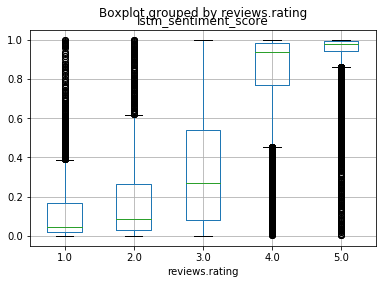

In [465]:
df.boxplot(column="lstm_sentiment_score", by="reviews.rating")

<Figure size 432x288 with 0 Axes>

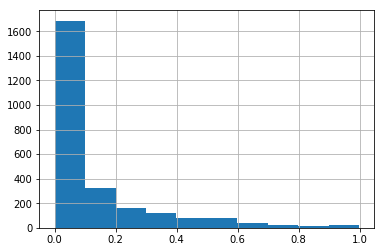

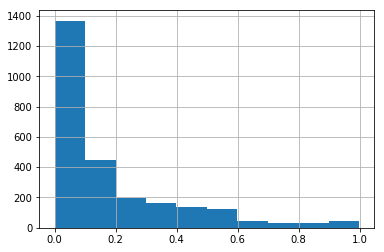

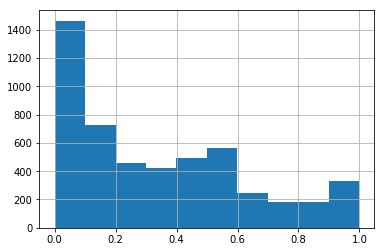

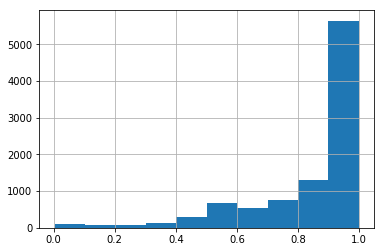

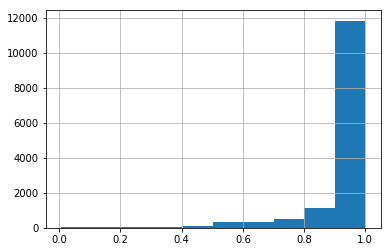

<Figure size 432x288 with 0 Axes>

In [468]:
df[df["reviews.rating"] == 1.0]["lstm_sentiment_score"].hist()
plt.figure()
df[df["reviews.rating"] == 2.0]["lstm_sentiment_score"].hist()
plt.figure()
df[df["reviews.rating"] == 3.0]["lstm_sentiment_score"].hist()
plt.figure()
df[df["reviews.rating"] == 4.0]["lstm_sentiment_score"].hist()
plt.figure()
df[df["reviews.rating"] == 5.0]["lstm_sentiment_score"].hist()
plt.figure()